In [1]:
# importing python utility libraries
import os, sys, random, io, urllib
from datetime import datetime

# importing pytorch libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

# importing python plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
from IPython.display import Image, display

In [2]:
USE_CUDA = False

In [3]:
# init deterministic seed
seed_value = 1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    torch.cuda.manual_seed(seed_value) # set pytorch seed GPU

In [4]:
# load the synthetic ERP dataset
ori_dataset = pd.read_csv('./data/fraud_dataset_v2.csv')


We augmented the dataset and renamed the attributes to appear more similar to a real-world dataset that one usually observes in SAP-ERP systems as part of SAP's Finance and Cost controlling (FICO) module. 

The dataset contains a subset of in total 7 categorical and 2 numerical attributes available in the FICO BKPF (containing the posted journal entry headers) and BSEG (containing the posted journal entry segments) tables. Please, find below a list of the individual attributes as well as a brief description of their respective semantics:

>- `BELNR`: the accounting document number,
>- `BUKRS`: the company code,
>- `BSCHL`: the posting key,
>- `HKONT`: the posted general ledger account,
>- `PRCTR`: the posted profit center,
>- `WAERS`: the currency key,
>- `KTOSL`: the general ledger account key,
>- `DMBTR`: the amount in local currency,
>- `WRBTR`: the amount in document currency.

In [5]:
# remove the "ground-truth" label information for the following steps of the lab
label = ori_dataset.pop('label')

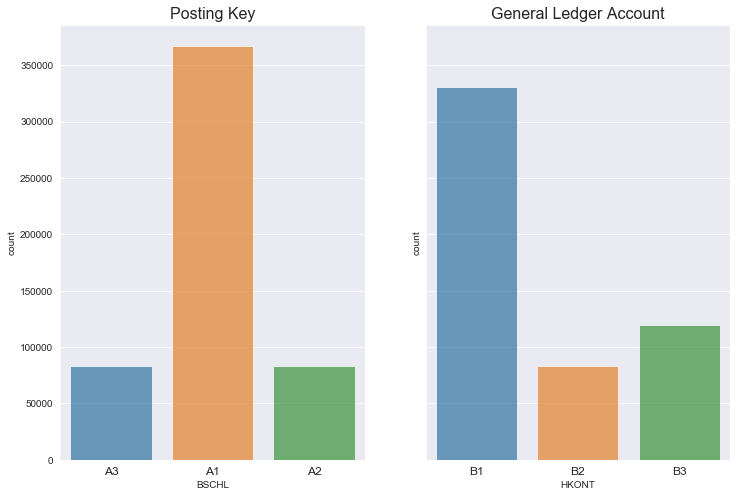

In [6]:
# prepare to plot posting key and general ledger account side by side
fig, ax = plt.subplots(1,2, sharey='row')
fig.set_figwidth(12)
fig.set_figheight(8)

plt.rc('font', size=18) 
# plot the distribution of the posting key attribute
g = sns.countplot(x=ori_dataset.loc[label=='regular', 'BSCHL'], ax=ax[0], alpha=0.7)
g.set_xticklabels(g.get_xticklabels(), rotation=0, size=12)
g.set_title('Posting Key', size=16)

# plot the distribution of the general ledger account attribute
g = sns.countplot(x=ori_dataset.loc[label=='regular', 'HKONT'], ax=ax[1], alpha=0.7)
g.set_xticklabels(g.get_xticklabels(), rotation=0, size=12)
g.set_title('General Ledger Account', size=16);

In [7]:
# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['KTOSL', 'PRCTR', 'BSCHL', 'HKONT', 'BUKRS', 'WAERS']

# encode categorical attributes into a binary one-hot encoded representation 
ori_dataset_categ_transformed = pd.get_dummies(ori_dataset[categorical_attr_names])

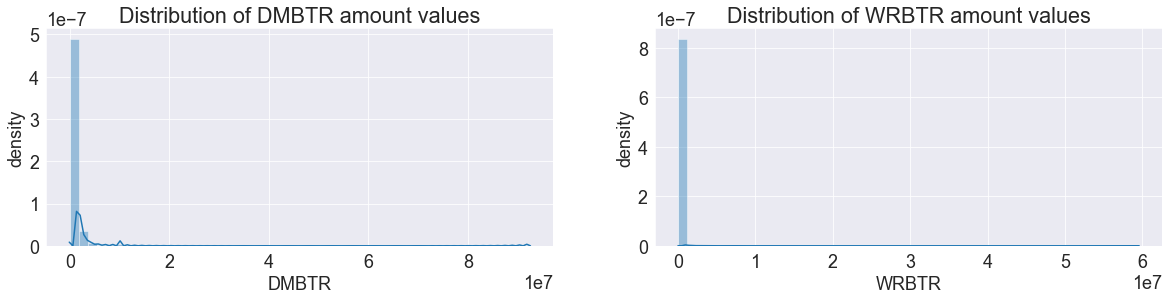

In [8]:
# init the plots
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset['DMBTR'].tolist(), ax=ax[0])
g.set_title('Distribution of DMBTR amount values')

# set axis-labels 
ax[0].set_xlabel('DMBTR')
ax[0].set_ylabel('density')

# plot distribution of the document amount attribute
g = sns.distplot(ori_dataset['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of WRBTR amount values')

# set axis-labels
ax[1].set_xlabel('WRBTR')
ax[1].set_ylabel('density');

In [9]:
# select "DMBTR" vs. "WRBTR" attribute
numeric_attr_names = ['DMBTR', 'WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_dataset[numeric_attr_names] + 1e-4
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
ori_dataset_numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

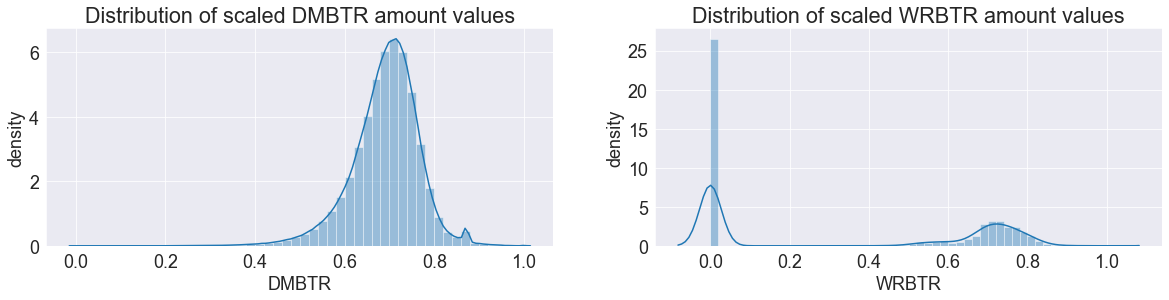

In [10]:
# init the plots
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset_numeric_attr['DMBTR'].tolist(), ax=ax[0])
g.set_title('Distribution of scaled DMBTR amount values')

# set axis-labels 
ax[0].set_xlabel('DMBTR')
ax[0].set_ylabel('density')

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset_numeric_attr['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of scaled WRBTR amount values')

# set axis-labels
ax[1].set_xlabel('WRBTR')
ax[1].set_ylabel('density');

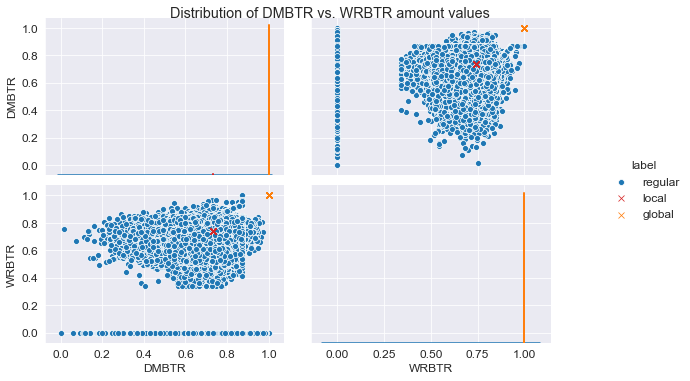

In [11]:
# append 'label' attribute 
numeric_attr_vis = ori_dataset_numeric_attr.copy()
numeric_attr_vis['label'] = label
plt.rc('font', size=12) 
# plot the log-scaled and min-max normalized numeric attributes
g = sns.pairplot(data=numeric_attr_vis, vars=numeric_attr_names, hue='label', palette={'regular': 'C0', 'local': 'C3', 'global': 'C1'}, markers=['o', 'x', 'x'])

# set figure title
g.fig.suptitle('Distribution of DMBTR vs. WRBTR amount values', y=1.02)

# set figure size
g.fig.set_size_inches(10, 5)

In [12]:
# merge categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_dataset_categ_transformed, ori_dataset_numeric_attr], axis = 1)

In [13]:
# inspect final dimensions of pre-processed transactional data
ori_subset_transformed.shape

(533009, 618)

In [14]:
# define encoder class
class Encoder(nn.Module):

    # define class constructor
    def __init__(self, input_size, hidden_size):

        # call super class constructor
        super(Encoder, self).__init__()

        # specify first layer - in 618, out 256
        self.map_L1 = nn.Linear(input_size, hidden_size[0], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 256, out 64
        self.map_L2 = nn.Linear(hidden_size[0], hidden_size[1], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 64, out 16
        self.map_L3 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fourth layer - in 16, out 4
        self.map_L4 = nn.Linear(hidden_size[2], hidden_size[3], bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_R4 = torch.nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        '''
        # specify fifth layer - in 4, out 2
        self.map_L5 = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_L5.weight)
        nn.init.constant_(self.map_L5.bias, 0.0)
        self.map_R5 = torch.nn.LeakyReLU(negative_slope=0.4, inplace=True)
        '''
        
        # define forward layer for mu and var
        self.map_mu = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_mu.weight)
        nn.init.constant_(self.map_mu.weight, 0.0)
        self.map_var = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_var.weight)
        nn.init.constant_(self.map_var.weight, 0.0)        
        
        
    # define reparameterize method
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_R4(self.map_L4(x))
        #x = self.map_R5(self.map_L5(x))
        
        # Calculate mu, logvar and pass to reparameterize method
        mu, logvar = self.map_mu(x), self.map_var(x)
        z = self.reparameterize(mu, logvar)
        
        # return result
        return z, mu, logvar

In [15]:
# init training network classes / architectures
encoder_train = Encoder(input_size=ori_subset_transformed.shape[1], hidden_size=[256, 64, 16, 4, 2])

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    encoder_train = encoder_train.cuda()

In [16]:
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] variational-encoder-generator architecture:\n\n{}\n'.format(now, encoder_train))

[LOG 20200504-21:56:44] variational-encoder-generator architecture:

Encoder(
  (map_L1): Linear(in_features=618, out_features=256, bias=True)
  (map_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L2): Linear(in_features=256, out_features=64, bias=True)
  (map_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L3): Linear(in_features=64, out_features=16, bias=True)
  (map_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L4): Linear(in_features=16, out_features=4, bias=True)
  (map_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_mu): Linear(in_features=4, out_features=2, bias=True)
  (map_var): Linear(in_features=4, out_features=2, bias=True)
)



In [17]:
# define decoder class
class Decoder(nn.Module):

    # define class constructor
    def __init__(self, output_size, hidden_size):

        # call super class constructor
        super(Decoder, self).__init__()

        # specify first layer - in 2, out 4
        self.map_L1 = nn.Linear(hidden_size[0], hidden_size[1], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 4, out 16
        self.map_L2 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 16, out 64
        self.map_L3 = nn.Linear(hidden_size[2], hidden_size[3], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fourth layer - in 64, out 256
        self.map_L4 = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify fifth layer - in 256, out 618
        self.map_L5 = nn.Linear(hidden_size[4], output_size, bias=True)
        nn.init.xavier_uniform_(self.map_L5.weight)
        nn.init.constant_(self.map_L5.bias, 0.0)
        self.map_S5 = torch.nn.Sigmoid()

    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_R4(self.map_L4(x))
        x = self.map_S5(self.map_L5(x))

        # return result
        return x

In [18]:
# init training network classes / architectures
decoder_train = Decoder(output_size=ori_subset_transformed.shape[1], hidden_size=[2, 4, 16, 64, 256])

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    decoder_train = decoder_train.cuda()
    
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 20200504-21:56:44] decoder architecture:

Decoder(
  (map_L1): Linear(in_features=2, out_features=4, bias=True)
  (map_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L2): Linear(in_features=4, out_features=16, bias=True)
  (map_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L3): Linear(in_features=16, out_features=64, bias=True)
  (map_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L4): Linear(in_features=64, out_features=256, bias=True)
  (map_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L5): Linear(in_features=256, out_features=618, bias=True)
  (map_S5): Sigmoid()
)



In [19]:
# define discriminator class
class Discriminator(nn.Module):

    # define class constructor
    def __init__(self, input_size, hidden_size, output_size):

        # call super class constructor
        super(Discriminator, self).__init__()

        # specify first layer - in 2, out 256
        self.map_L1 = nn.Linear(input_size, hidden_size[0], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 256, out 16
        self.map_L2 = nn.Linear(hidden_size[0], hidden_size[1], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 16, out 4
        self.map_L3 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify fourth layer - in 4, out 2
        self.map_L4 = nn.Linear(hidden_size[2], output_size, bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_S4 = torch.nn.Sigmoid()

    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_S4(self.map_L4(x))

        # return result
        return x

In [20]:
# init training network classes / architectures
discriminator_train = Discriminator(input_size=2, hidden_size=[256, 16, 4, 2], output_size=1)

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    discriminator_train = discriminator_train.cuda()
    
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] discriminator architecture:\n\n{}\n'.format(now, discriminator_train))

[LOG 20200504-21:56:44] discriminator architecture:

Discriminator(
  (map_L1): Linear(in_features=2, out_features=256, bias=True)
  (map_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L2): Linear(in_features=256, out_features=16, bias=True)
  (map_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L3): Linear(in_features=16, out_features=4, bias=True)
  (map_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (map_L4): Linear(in_features=4, out_features=1, bias=True)
  (map_S4): Sigmoid()
)



In [21]:
# define the optimization criterion / loss function
reconstruction_criterion_categorical = nn.BCELoss(reduction='mean')
reconstruction_criterion_numeric = nn.MSELoss(reduction='mean')

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    reconstruction_criterion_categorical = reconstruction_criterion_categorical.cuda()
    reconstruction_criterion_numeric = reconstruction_criterion_numeric.cuda()

In [22]:
# define encoder and decoded learning rate
learning_rate_enc = 1e-3
learning_rate_dec = 1e-3

# define encoder and decoder optimization strategy
encoder_optimizer = optim.Adam(encoder_train.parameters(), lr=learning_rate_enc)
decoder_optimizer = optim.Adam(decoder_train.parameters(), lr=learning_rate_dec)

In [23]:
# init the discriminator losses
discriminator_criterion = nn.BCELoss()

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    discriminator_criterion = discriminator_criterion.cuda()

In [24]:
# define generator and discriminator learning rate
learning_rate_dis_z = 1e-5

# define generator and discriminator optimization strategy
discriminator_optimizer = optim.Adam(discriminator_train.parameters(), lr=learning_rate_dis_z)

In [25]:
# define the number of gaussians
tau = 5 

# define radius of each gaussian
radius = 0.8

# define the sigma of each gaussian
sigma = 0.01

# define the dimensionality of each gaussian
dim = 2

# determine x and y coordinates of the target mixture of gaussians
x_centroid = (radius * np.sin(np.linspace(0, 2 * np.pi, tau, endpoint=False)) + 1) / 2
y_centroid = (radius * np.cos(np.linspace(0, 2 * np.pi, tau, endpoint=False)) + 1) / 2

# determine each gaussians mean (centroid) and standard deviation
mu_gauss = np.vstack([x_centroid, y_centroid]).T

# determine the number of samples to be created per gaussian
samples_per_gaussian = 100000

# iterate over the number of distinct gaussians
for i, mu in enumerate(mu_gauss):

    # case: first gaussian
    if i == 0:

        # randomly sample from gaussion distribution 
        z_continous_samples_all = np.random.normal(mu, sigma, size=(samples_per_gaussian, dim))

    # case: non-first gaussian
    else:

        # randomly sample from gaussian distribution
        z_continous_samples = np.random.normal(mu, sigma, size=(samples_per_gaussian, dim))

        # collect and stack new samples
        z_continous_samples_all = np.vstack([z_continous_samples_all, z_continous_samples])

Let's visually inspect the generated prior distribution $p(z)$:

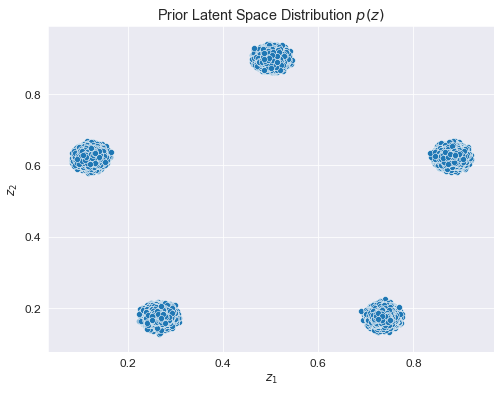

In [26]:
# init the plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# plot reconstruction error scatter plot
ax.scatter(z_continous_samples_all[:, 0], z_continous_samples_all[:, 1], c='C0', marker="o", edgecolors='w', linewidth=0.5) 
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

# add plot title
ax.set_title('Prior Latent Space Distribution $p(z)$');

In [27]:
# specify training parameters
num_epochs = 5000
mini_batch_size = 1024

In [28]:
encoder_train.load_state_dict(torch.load('./models_VAEGAN_batch128/ep_2000_encoder_model.pth', map_location=torch.device('cpu')))
decoder_train.load_state_dict(torch.load('./models_VAEGAN_batch128/ep_2000_decoder_model.pth', map_location=torch.device('cpu')))
discriminator_train.load_state_dict(torch.load('./models_VAEGAN_batch128/ep_2000_discriminator_model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [29]:
encoder_eval = encoder_train
decoder_eval = decoder_train
# convert pre-processed data to pytorch tensor
torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()

# convert to pytorch tensor - none cuda enabled
dataloader_eval = DataLoader(torch_dataset, batch_size=131072, shuffle=False, num_workers=0)
# determine if CUDA is available at the compute node
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    # push dataloader to CUDA
    dataloader_eval = DataLoader(torch_dataset.cuda(), batch_size=mini_batch_size, shuffle=False)

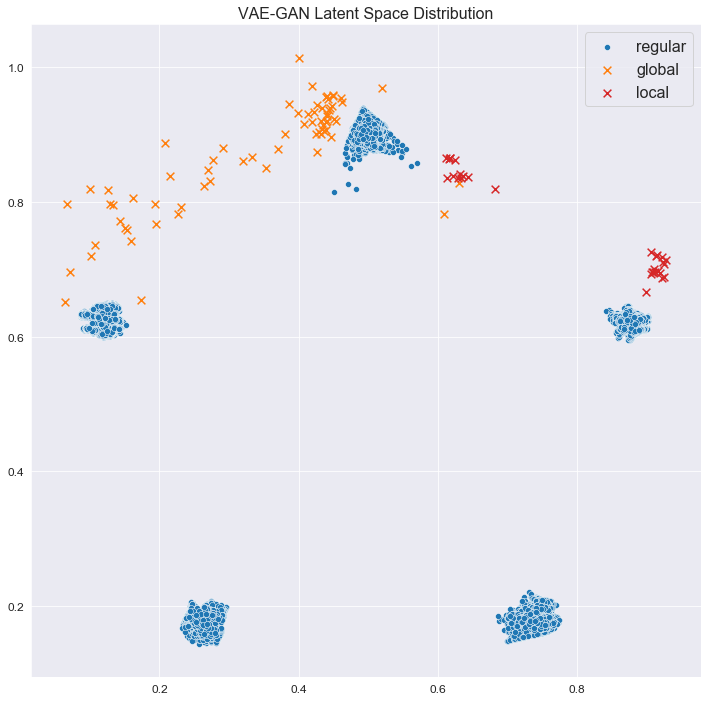

In [30]:
# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# init batch count
batch_count = 0

# iterate over epoch mini batches
for enc_transactions_batch in dataloader_eval:
    with torch.no_grad():
        # determine latent space representation of all transactions
        z_enc_transactions_batch,_,_ = encoder_eval(enc_transactions_batch)
        # case: initial batch 
        if batch_count == 0:

            # collect reconstruction errors of batch
            z_enc_transactions_all = z_enc_transactions_batch

        # case: non-initial batch
        else:
            # collect reconstruction errors of batch
            z_enc_transactions_all = torch.cat((z_enc_transactions_all, z_enc_transactions_batch), 0)
            
        # increase batch count
        batch_count += 1

# convert to numpy array
z_enc_transactions_all = z_enc_transactions_all.detach().numpy()

# prepare plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

# obtain regular transactions as well as global and local anomalies
regular_data = z_enc_transactions_all[label == 'regular']
global_outliers = z_enc_transactions_all[label == 'global']
local_outliers = z_enc_transactions_all[label == 'local']

# plot reconstruction error scatter plot
ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', marker="o", label='regular', edgecolors='w', linewidth=0.5) # plot regular transactions
ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="x", label='global', edgecolors='w', s=60) # plot global outliers
ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C3', marker="x", label='local', edgecolors='w', s=60) # plot local outliers

# add plot legend of transaction classes
plt.title("VAE-GAN Latent Space Distribution", size=16)
ax.legend(loc='best', prop={'size': 16});
plt.savefig('VAE_GAN_Latent')

In [31]:
n = z_enc_transactions_all.shape[0]

split_ratio = 0.65
# Training Testing Split
z_enc_transactions_test = z_enc_transactions_all[int(n*split_ratio):]
z_enc_transactions_all = z_enc_transactions_all[:int(n*split_ratio)]

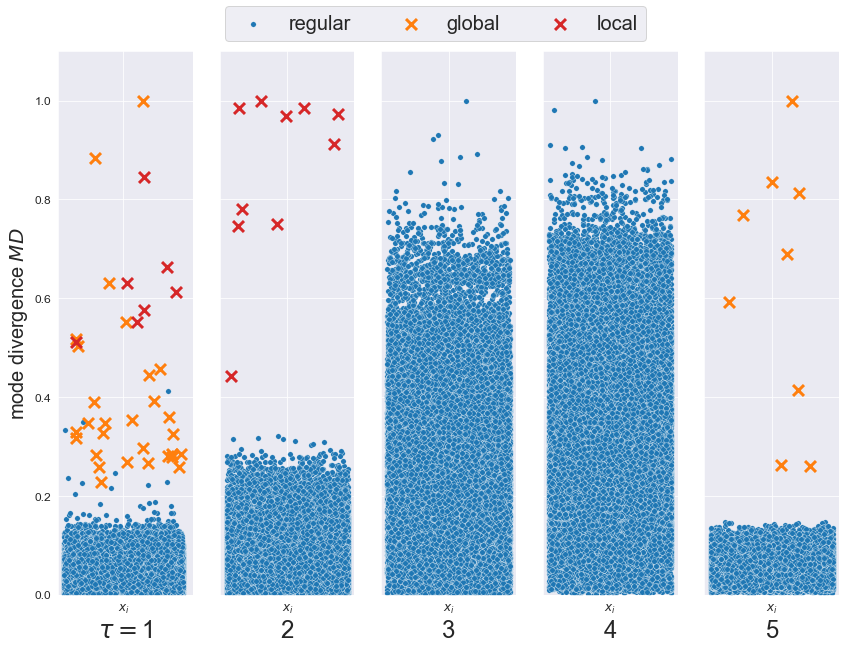

In [32]:







# define euclidean distance calculation
def compute_euclid_distance(x, y):
    
    # calculate euclidean distance 
    euclidean_distance = np.sqrt(np.sum((x - y) ** 2, axis=1))
    
    # return euclidean distance
    return euclidean_distance

# determine distance to each mode
distances = np.apply_along_axis(func1d=compute_euclid_distance, 
                                axis=1, arr=z_enc_transactions_all, y=mu_gauss)

# determine mode divergence
mode_divergence = np.min(distances, axis=1)

# determine min-mode id
cluster_ids = np.argmin(distances, axis=1) 

# normalize the mode divergences of each mode
# prepare empty arrays of the same shape and dtype
mode_divergence_all_scaled = np.asarray(mode_divergence)

# iterate over the cluster modes
for cluster_id in np.unique(cluster_ids).tolist():
  
    # determine journal entries of current mode
    mask = cluster_ids == cluster_id

    # normalize mode journal entries mode divergence to the range [0,1]
    mode_divergence_all_scaled[mask] = (mode_divergence[mask] - mode_divergence[mask].min()) / (mode_divergence[mask].ptp())   


# collect anomaly score, labels and cluster assignments
plot_data = pd.concat([pd.Series(mode_divergence_all_scaled, name='mode_divergence'), 
                       pd.Series(label[:int(n*split_ratio)], name='label'),                        
                       pd.Series(cluster_ids, name='cluster_id')],
                     axis=1)
num_clusters = len(np.unique(cluster_ids))
# init sub-plots based on the number of modes
fig, axes = plt.subplots(1, num_clusters, sharey=True, figsize=(14, 10))


# iterate over distinct modes
for mode in range(0, num_clusters):

    plot_data = plot_data.sample(frac=1.0)
    # collect features of current mode
    z_mode = plot_data[plot_data['cluster_id'] == mode]

    regular_data = z_mode[z_mode['label'] == 'regular']
    global_outliers = z_mode[z_mode['label'] == 'global']
    local_outliers = z_mode[z_mode['label'] == 'local']

    # create train scatter plot of regular samples
    axes[mode].scatter(regular_data.index, regular_data['mode_divergence'],
                       c='C0', marker='o', s=30, linewidth=0.3, label='regular', edgecolors='w')
    
    # create train scatter plot of global anomalies
    axes[mode].scatter(global_outliers.index, global_outliers['mode_divergence'],
                               c='C1', marker='x', s=120, linewidth=3, label='global', edgecolors='w')
    # create train scatter plot of local anomalies
    axes[mode].scatter(local_outliers.index, local_outliers['mode_divergence'],
                               c='C3', marker='x', s=120, linewidth=3, label='local', edgecolors='w')

    # set axis labels
    xlabel = '$\\tau={}$' + str(mode+1) if mode == 0 else str(mode+1)
    axes[mode].set_xlabel(xlabel, fontsize=24)

    # set axis limits
    axes[mode].set_ylim([0.0, 1.1])

    axes[mode].set_xticks([int(plot_data.shape[0]/2)])
    axes[mode].set_xticklabels(['$x_{i}$'])

# set axis labels
axes[0].set_ylabel('mode divergence $MD$', fontsize=20)

# add legend to plot
handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, loc='center', fontsize=20, ncol=3, borderaxespad=0.,
           bbox_to_anchor=(-6.5, 1., 9., .1))

# set grid and tight plotting layout
plt.grid(True)


################################################################
################################################################
################################################################
# define the optimization criterion / loss function
reconstruction_criterion_categorical_eval = nn.BCEWithLogitsLoss(reduction='none')
reconstruction_criterion_numeric_eval = nn.MSELoss(reduction='none')

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    reconstruction_criterion_categorical_eval = reconstruction_criterion_categorical_eval.cuda()
    reconstruction_criterion_numeric_eval = reconstruction_criterion_numeric_eval.cuda()

# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# init batch count
batch_count = 0

# iterate over epoch mini batches
for enc_transactions_batch in dataloader_eval:

    # determine latent space representation of all transactions
    z_enc_transactions_batch,_,_ = encoder_eval(enc_transactions_batch)

    # reconstruct input samples
    reconstruction_batch = decoder_eval(z_enc_transactions_batch)

    # split input transactions into numeric and categorical parts
    input_cat_all = enc_transactions_batch[:, :ori_dataset_categ_transformed.shape[1]]
    input_num_all = enc_transactions_batch[:, ori_dataset_categ_transformed.shape[1]:]

    # split reconstruction into numeric and categorical parts
    rec_cat_all = reconstruction_batch[:, :ori_dataset_categ_transformed.shape[1]]
    rec_num_all = reconstruction_batch[:, ori_dataset_categ_transformed.shape[1]:]

    # compute rec error
    rec_error_cat_all = reconstruction_criterion_categorical_eval(input=rec_cat_all, target=input_cat_all).mean(dim=1)
    rec_error_num_all = reconstruction_criterion_numeric_eval(input=rec_num_all, target=input_num_all).mean(dim=1)

    # combine categorical and numerical errors
    rec_error_all_batch = rec_error_cat_all + rec_error_num_all
    
    # case: initial batch
    if batch_count == 0:
    
        # collect reconstruction errors of batch
        rec_error_all = rec_error_all_batch
    
    # case: non-initial batch
    else:
      
        # collect reconstruction errors of batch
        rec_error_all = torch.cat((rec_error_all, rec_error_all_batch), dim=0)
    
    # increase batch count
    batch_count += 1

# convert to numpy array
rec_error_all = rec_error_all.cpu().detach().numpy()
plt.savefig('VAE_GAN_Training_MD')

In [33]:
rec_error_test = rec_error_all[int(n*split_ratio):]
rec_error_all = rec_error_all[:int(n*split_ratio)]

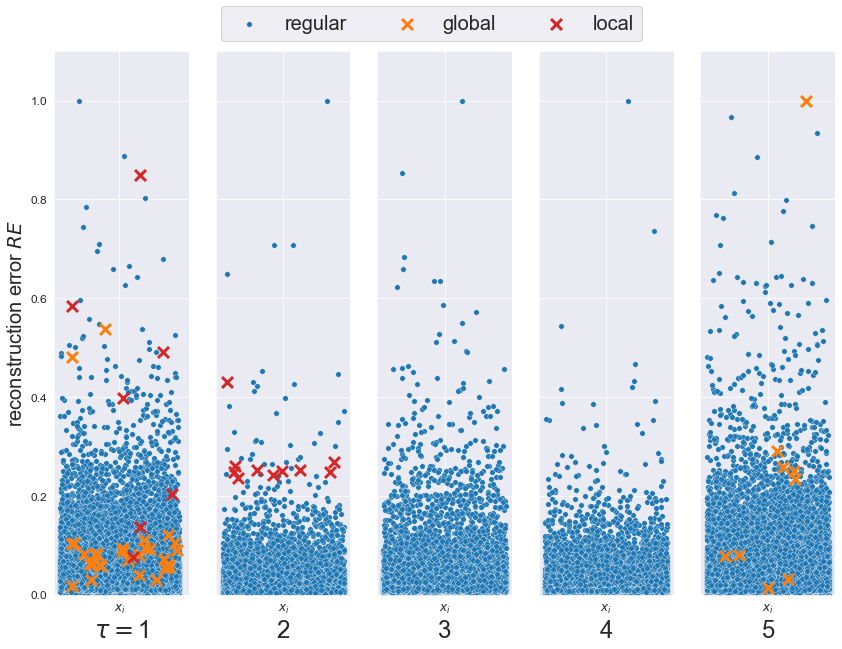

In [34]:
# normalize the reconstruction errors of each mode

# prepare empty arrays of the same shape and dtype
rec_error_all_scaled = np.asarray(rec_error_all)

# iterate over the cluster modes
for cluster_id in np.unique(cluster_ids).tolist():
  
    # determine journal entries of current mode
    mask = cluster_ids == cluster_id
    # normalize mode journal entries reconstruction error to the range [0,1]
    rec_error_all_scaled[mask] = (rec_error_all[mask] - rec_error_all[mask].min()) / (rec_error_all[mask].ptp())


# collect anomaly score, labels and cluster assignments
plot_data = pd.concat([pd.Series(rec_error_all_scaled, name='rec_error'), 
                       pd.Series(label[:int(n*split_ratio)], name='label'),                        
                       pd.Series(cluster_ids, name='cluster_id')],
                     axis=1)

num_clusters = len(np.unique(cluster_ids))
# init sub-plots based on the number of modes
fig, axes = plt.subplots(1, num_clusters, sharey=True, figsize=(14, 10))


# iterate over distinct modes
for mode in range(0, num_clusters):

    plot_data = plot_data.sample(frac=1.0)
    # collect features of current mode
    z_mode = plot_data[plot_data['cluster_id'] == mode]

    regular_data = z_mode[z_mode['label'] == 'regular']
    global_outliers = z_mode[z_mode['label'] == 'global']
    local_outliers = z_mode[z_mode['label'] == 'local']

    # create train scatter plot of regular samples
    axes[mode].scatter(regular_data.index, regular_data['rec_error'],
                       c='C0', marker='o', s=30, linewidth=0.3, label='regular', edgecolors='w')
    
    # create train scatter plot of global anomalies
    axes[mode].scatter(global_outliers.index, global_outliers['rec_error'],
                               c='C1', marker='x', s=120, linewidth=3, label='global', edgecolors='w')
    # create train scatter plot of local anomalies
    axes[mode].scatter(local_outliers.index, local_outliers['rec_error'],
                               c='C3', marker='x', s=120, linewidth=3, label='local', edgecolors='w')

    # set axis labels
    xlabel = '$\\tau={}$' + str(mode+1) if mode == 0 else str(mode+1)
    axes[mode].set_xlabel(xlabel, fontsize=24)

    # set axis limits
    axes[mode].set_ylim([0.0, 1.1])

    axes[mode].set_xticks([int(plot_data.shape[0]/2)])
    axes[mode].set_xticklabels(['$x_{i}$'])

# set axis labels
axes[0].set_ylabel('reconstruction error $RE$', fontsize=20)

# add legend to plot
handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, loc='center', fontsize=20, ncol=3, borderaxespad=0.,
           bbox_to_anchor=(-6.5, 1., 9., .1))

# set grid and tight plotting layout
plt.grid(True)
plt.savefig('VAE_GAN_Training_RE')

# ROC Curve

In [35]:
# find the cluster that contain the most anomaly points

label_train = label[:int(n*split_ratio)]
cluster_anomaly_number = [0]*5
# iterate over the cluster modes
for cluster_id in np.unique(cluster_ids).tolist():
  
    # determine journal entries of current mode
    mask = cluster_ids == cluster_id
    cluster_anomaly_number[cluster_id] = sum(label_train[mask] != 'regular')
non_regular_clusters = list(np.nonzero(cluster_anomaly_number)[0])
non_regular_clusters

[0, 1, 4]

In [36]:
from sklearn.metrics import roc_curve

mask = np.isin(cluster_ids, non_regular_clusters)
y_true = (label != 'regular')[:int(n*split_ratio)]


tpr_target = 0.8
k = 55
# running a similar analysis ONLY in that cluster
rec_error_all_scaled_cluster = rec_error_all_scaled[mask]
mode_divergence_all_scaled_cluster = mode_divergence_all_scaled[mask]
y_true_cluster = y_true[mask]

# set alpha_list 
alpha_list = np.arange(11)/10

max_precision = -1e10
best_alpha = None
best_th = None
for alpha in alpha_list:
    # determine journal entry anomaly score
    anomaly_score_cluster = alpha * rec_error_all_scaled_cluster + (1.0 - alpha) * mode_divergence_all_scaled_cluster
    fpr, tpr, threshs = roc_curve(y_true_cluster, anomaly_score_cluster)

    th = threshs[np.argmax(tpr >= tpr_target) + 1]
    
    tp = sum(y_true_cluster[anomaly_score_cluster > th])
    fp = sum(anomaly_score_cluster > th) - tp
    fn = sum(y_true_cluster[anomaly_score_cluster <= th])
    tn = sum(anomaly_score_cluster <= th) - fn
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    
    top_k = (-anomaly_score_cluster).argsort()[:k]
    top_k_pos_rate = sum(y_true_cluster.values[top_k])/ k

    print('alpha: ', alpha,' precision: ', precision, 'top-k ', top_k_pos_rate, 'F1-score', f1, 'recall ', recall)
    if precision > max_precision:
        max_precision = precision
        best_alpha = alpha
        best_th = th
print("best alpha: ", best_alpha)

alpha:  0.0  precision:  0.676923076923077 top-k  0.7818181818181819 F1-score 0.7333333333333334 recall  0.8
alpha:  0.1  precision:  0.8 top-k  0.8 F1-score 0.8000000000000002 recall  0.8
alpha:  0.2  precision:  0.8301886792452831 top-k  0.8181818181818182 F1-score 0.8148148148148149 recall  0.8
alpha:  0.3  precision:  0.5641025641025641 top-k  0.7272727272727273 F1-score 0.6616541353383458 recall  0.8
alpha:  0.4  precision:  0.2634730538922156 top-k  0.5818181818181818 F1-score 0.3963963963963964 recall  0.8
alpha:  0.5  precision:  0.11989100817438691 top-k  0.4727272727272727 F1-score 0.20853080568720378 recall  0.8
alpha:  0.6  precision:  0.05648267008985879 top-k  0.38181818181818183 F1-score 0.10551558752997603 recall  0.8
alpha:  0.7  precision:  0.02786573780873971 top-k  0.21818181818181817 F1-score 0.05385556915544676 recall  0.8
alpha:  0.8  precision:  0.01261467889908257 top-k  0.09090909090909091 F1-score 0.024837708156929157 recall  0.8
alpha:  0.9  precision:  0.00

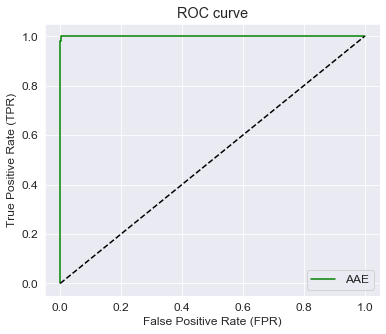

In [37]:
anomaly_score_cluster = best_alpha * rec_error_all_scaled_cluster + (1.0 - best_alpha) * mode_divergence_all_scaled_cluster
fpr, tpr, _ = roc_curve(y_true_cluster, anomaly_score_cluster)
fig, ax = plt.subplots(figsize = (6,5))
ax.plot(fpr, tpr, "g-", label = "AAE")
ax.plot([0,1],[0,1],"k--")
ax.set(xlabel = "False Positive Rate (FPR)",
       ylabel = "True Positive Rate (TPR)",
       title = "ROC curve")
ax.legend();
plt.savefig('VAE_GAN_Training_ROC')

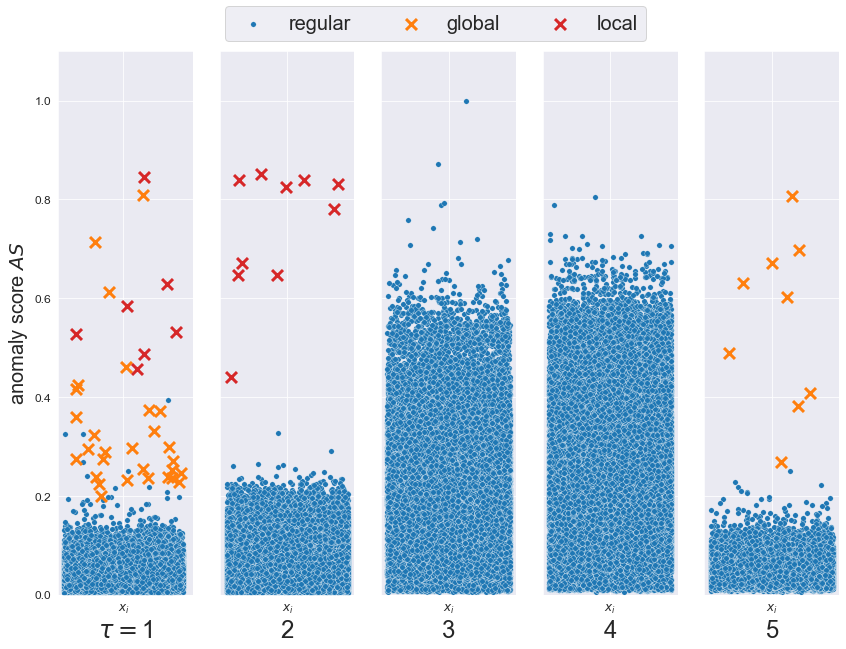

In [38]:
anomaly_score = best_alpha * rec_error_all_scaled + (1.0 - best_alpha) * mode_divergence_all_scaled
# collect anomaly score, labels and cluster assignments
plot_data = pd.concat([pd.Series(anomaly_score, name='anomaly_score'), 
                       pd.Series(label[:int(n*split_ratio)], name='label'),                        
                       pd.Series(cluster_ids, name='cluster_id')],
                     axis=1)

num_clusters = len(np.unique(cluster_ids))
# init sub-plots based on the number of modes
fig, axes = plt.subplots(1, num_clusters, sharey=True, figsize=(14, 10))

# iterate over distinct modes
for mode in range(0, num_clusters):

    plot_data = plot_data.sample(frac=1.0)
    # collect features of current mode
    z_mode = plot_data[plot_data['cluster_id'] == mode]

    regular_data = z_mode[z_mode['label'] == 'regular']
    global_outliers = z_mode[z_mode['label'] == 'global']
    local_outliers = z_mode[z_mode['label'] == 'local']

    # create train scatter plot of regular samples
    axes[mode].scatter(regular_data.index, regular_data['anomaly_score'],
                       c='C0', marker='o', s=30, linewidth=0.3, label='regular', edgecolors='w')
    
    # create train scatter plot of global anomalies
    axes[mode].scatter(global_outliers.index, global_outliers['anomaly_score'],
                               c='C1', marker='x', s=120, linewidth=3, label='global', edgecolors='w')
    # create train scatter plot of local anomalies
    axes[mode].scatter(local_outliers.index, local_outliers['anomaly_score'],
                               c='C3', marker='x', s=120, linewidth=3, label='local', edgecolors='w')

    # set axis labels
    xlabel = '$\\tau={}$' + str(mode+1) if mode == 0 else str(mode+1)
    axes[mode].set_xlabel(xlabel, fontsize=24)

    # set axis limits
    axes[mode].set_ylim([0.0, 1.1])

    axes[mode].set_xticks([int(plot_data.shape[0]/2)])
    axes[mode].set_xticklabels(['$x_{i}$'])

# set axis labels
axes[0].set_ylabel('anomaly score $AS$', fontsize=20)

# add legend to plot
handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, loc='center', fontsize=20, ncol=3, borderaxespad=0.,
           bbox_to_anchor=(-6.5, 1., 9., .1))

# set grid and tight plotting layout
plt.grid(True)
plt.savefig('VAE_GAN_Training_AS')

In [39]:
best_th

0.2592385361455284

# Testing

In [40]:
# testing
# Construct RE and MD

# determine distance to each mode
distances = np.apply_along_axis(func1d=compute_euclid_distance, 
                                axis=1, arr=z_enc_transactions_test, y=mu_gauss)

# determine mode divergence
mode_divergence = np.min(distances, axis=1)

# determine min-mode id
cluster_ids = np.argmin(distances, axis=1) 

# normalize the mode divergences of each mode
# prepare empty arrays of the same shape and dtype
mode_divergence_all_scaled = np.asarray(mode_divergence)

# iterate over the cluster modes
for cluster_id in np.unique(cluster_ids).tolist():
  
    # determine journal entries of current mode
    mask = cluster_ids == cluster_id

    # normalize mode journal entries mode divergence to the range [0,1]
    mode_divergence_all_scaled[mask] = (mode_divergence[mask] - mode_divergence[mask].min()) / (mode_divergence[mask].ptp())   




In [41]:
# normalize the reconstruction errors of each mode

# prepare empty arrays of the same shape and dtype
rec_error_all_scaled = np.asarray(rec_error_test)

# iterate over the cluster modes
for cluster_id in np.unique(cluster_ids).tolist():
  
    # determine journal entries of current mode
    mask = cluster_ids == cluster_id
    # normalize mode journal entries reconstruction error to the range [0,1]
    rec_error_all_scaled[mask] = (rec_error_test[mask] - rec_error_test[mask].min()) / (rec_error_test[mask].ptp())



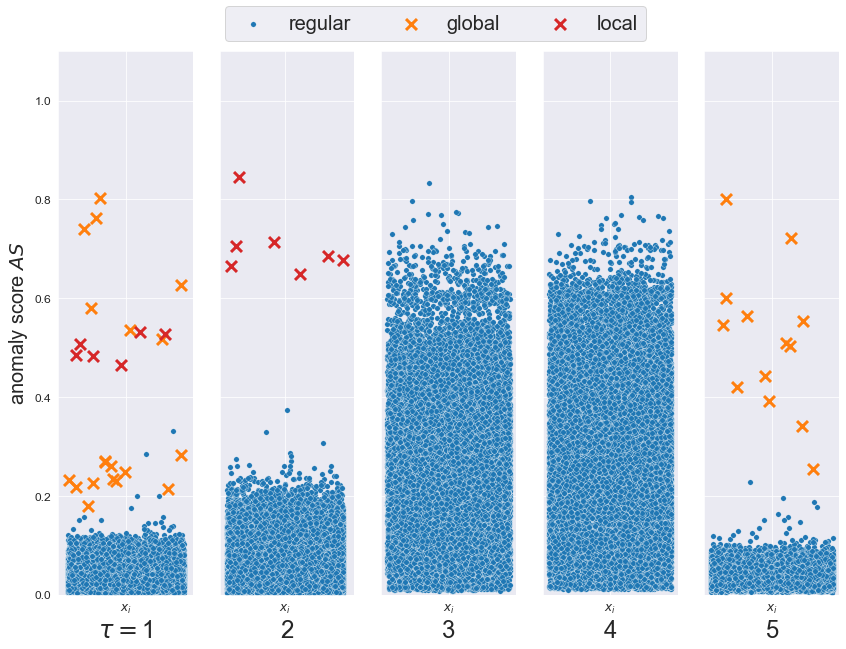

In [42]:
anomaly_score = best_alpha * rec_error_all_scaled + (1.0 - best_alpha) * mode_divergence_all_scaled
# collect anomaly score, labels and cluster assignments
plot_data = pd.concat([pd.Series(anomaly_score, name='anomaly_score'), 
                       pd.Series(list(label[int(n*split_ratio):]), name='label'),                        
                       pd.Series(cluster_ids, name='cluster_id')],
                     axis=1)

num_clusters = len(np.unique(cluster_ids))
# init sub-plots based on the number of modes
fig, axes = plt.subplots(1, num_clusters, sharey=True, figsize=(14, 10))

# iterate over distinct modes
for mode in range(0, num_clusters):

    plot_data = plot_data.sample(frac=1.0)
    # collect features of current mode
    z_mode = plot_data[plot_data['cluster_id'] == mode]

    regular_data = z_mode[z_mode['label'] == 'regular']
    global_outliers = z_mode[z_mode['label'] == 'global']
    local_outliers = z_mode[z_mode['label'] == 'local']

    # create train scatter plot of regular samples
    axes[mode].scatter(regular_data.index, regular_data['anomaly_score'],
                       c='C0', marker='o', s=30, linewidth=0.3, label='regular', edgecolors='w')
    
    # create train scatter plot of global anomalies
    axes[mode].scatter(global_outliers.index, global_outliers['anomaly_score'],
                               c='C1', marker='x', s=120, linewidth=3, label='global', edgecolors='w')
    # create train scatter plot of local anomalies
    axes[mode].scatter(local_outliers.index, local_outliers['anomaly_score'],
                               c='C3', marker='x', s=120, linewidth=3, label='local', edgecolors='w')

    # set axis labels
    xlabel = '$\\tau={}$' + str(mode+1) if mode == 0 else str(mode+1)
    axes[mode].set_xlabel(xlabel, fontsize=24)

    # set axis limits
    axes[mode].set_ylim([0.0, 1.1])

    axes[mode].set_xticks([int(plot_data.shape[0]/2)])
    axes[mode].set_xticklabels(['$x_{i}$'])

# set axis labels
axes[0].set_ylabel('anomaly score $AS$', fontsize=20)

# add legend to plot
handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, loc='center', fontsize=20, ncol=3, borderaxespad=0.,
           bbox_to_anchor=(-6.5, 1., 9., .1))

# set grid and tight plotting layout
plt.grid(True)
plt.savefig('VAE_GAN_Testing_AS')

In [43]:
y_true = (label!='regular')[int(n*split_ratio):]
print('best alpha: ', best_alpha, 'best threshold: ', best_th)

best alpha:  0.2 best threshold:  0.2592385361455284


In [44]:
non_regular_clusters

[0, 1, 4]

In [45]:
k = 45

mask = np.isin(cluster_ids, non_regular_clusters)
rec_error_all_scaled_cluster = rec_error_all_scaled[mask]
mode_divergence_all_scaled_cluster = mode_divergence_all_scaled[mask]


In [46]:
y_true_cluster = y_true[mask]
anomaly_score_cluster = best_alpha * rec_error_all_scaled_cluster + (1.0 - best_alpha) * mode_divergence_all_scaled_cluster



In [47]:
fpr, tpr, threshs = roc_curve(y_true_cluster, anomaly_score_cluster)

tp = sum(y_true_cluster[anomaly_score_cluster > best_th])
fp = sum(anomaly_score_cluster > best_th) - tp
fn = sum(y_true_cluster[anomaly_score_cluster <= best_th])
tn = sum(anomaly_score_cluster <= best_th) - fn

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)

top_k = (-anomaly_score_cluster).argsort()[:k]
top_k_pos_rate = sum(y_true_cluster.values[top_k])/ k
print('precision: ', precision, 'top-k ', top_k_pos_rate, 'F1-score', f1, 'recall: ', recall)

precision:  0.72 top-k  0.7777777777777778 F1-score 0.7578947368421052 recall:  0.8


In [48]:
sum(label_train != 'regular')

55

In [49]:
# # convert pre-processed data to pytorch tensor
# torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()

# # convert to pytorch tensor - none cuda enabled
# dataloader = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True, num_workers=0)
# # note: we set num_workers to zero to retrieve deterministic results

# # determine if CUDA is available at compute node
# if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
#     dataloader = DataLoader(torch_dataset.cuda(), batch_size=mini_batch_size, shuffle=True)

In [50]:
# # init collection of training losses
# epoch_reconstruction_losses = []
# #epoch_vae_losses = []
# epoch_discriminator_losses = []
# epoch_generator_losses = []

In [51]:
# mini_batch_verbose_step = 1000

In [52]:
# # initialize training adversarial autoencoder model
# for epoch in range(num_epochs):

#     # init mini batch counter
#     mini_batch_count = 0
    
#     # init epoch training losses
#     batch_reconstruction_losses = 0.0
#     batch_vae_losses = 0.0
#     batch_discriminator_losses = 0.0
#     batch_generator_losses = 0.0

#     # determine if GPU training is enabled
#     if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):

#         # set all networks / models in GPU mode
#         encoder_train.cuda()
#         decoder_train.cuda()
#         discriminator_train.cuda()

#     # set networks in training mode (apply dropout when needed)
#     encoder_train.train()
#     decoder_train.train()
#     discriminator_train.train()
    
#     # start timer
#     start_time = datetime.now()

#     # iterate over epoch mini batches
#     for mini_batch_data in dataloader:

#         # increase mini batch counter
#         mini_batch_count += 1

#         # determine if GPU training is enabled
#         if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
          
#             # convert mini batch to torch variable
#             mini_batch_torch = torch.cuda.FloatTensor(mini_batch_data)

#         else:
          
#              # convert mini batch to torch variable
#              mini_batch_torch = torch.FloatTensor(mini_batch_data)
        
#         # reset the networks gradients
#         encoder_train.zero_grad()
#         decoder_train.zero_grad()
#         discriminator_train.zero_grad()

#         # =================== reconstruction phase =====================
        
#         # run autoencoder encoding - decoding
#         z_sample, mu, logvar = encoder_train(mini_batch_torch)
#         mini_batch_reconstruction = decoder_train(z_sample)

#         # split input date to numerical and categorical part
#         batch_cat = mini_batch_torch[:, :ori_dataset_categ_transformed.shape[1]]
#         batch_num = mini_batch_torch[:, ori_dataset_categ_transformed.shape[1]:]
        
#         # split reconstruction to numerical and categorical part
#         rec_batch_cat = mini_batch_reconstruction[:, :ori_dataset_categ_transformed.shape[1]]
#         rec_batch_num = mini_batch_reconstruction[:, ori_dataset_categ_transformed.shape[1]:]

#         # backward pass + gradients update
#         rec_error_cat = reconstruction_criterion_categorical(input=rec_batch_cat, target=batch_cat)  # one-hot attr error
#         rec_error_num = reconstruction_criterion_numeric(input=rec_batch_num, target=batch_num)  # numeric attr error

#         # combine both reconstruction errors
#         # calculate vae loss
#         reconstruction_loss = rec_error_cat + rec_error_num
        
#         # run backward pass - determine gradients
#         reconstruction_loss.backward()
        
#         # collect batch reconstruction loss
#         batch_reconstruction_losses += reconstruction_loss.item()
        
#         # update network parameter - decoder and encoder
#         decoder_optimizer.step()
#         encoder_optimizer.step()

#         # =================== regularization phase =====================
#         # =================== discriminator training ===================

#         # set discriminator in evaluation mode
#         discriminator_train.eval()

#         # generate target latent space data
#         z_target_batch = z_continous_samples_all[random.sample(range(0, z_continous_samples_all.shape[0]), mini_batch_size),:]

#         # convert to torch tensor
#         z_target_batch = torch.FloatTensor(z_target_batch)

#         if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
#             z_target_batch = z_target_batch.cuda()

#         # determine mini batch sample generated by the encoder -> fake gaussian sample
#         z_fake_gauss, _, _ = encoder_train(mini_batch_torch)

#         # determine discriminator classification of both samples
#         d_real_gauss = discriminator_train(z_target_batch) # real sampled gaussian 
#         d_fake_gauss = discriminator_train(z_fake_gauss) # fake created gaussian

#         # determine discriminator classification target variables
#         d_real_gauss_target = torch.FloatTensor(torch.ones(d_real_gauss.shape)) # real -> 1
#         d_fake_gauss_target = torch.FloatTensor(torch.zeros(d_fake_gauss.shape)) # fake -> 0

#         # determine if GPU training is enabled
#         if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):

#             # push tensors to CUDA
#             d_real_gauss_target = d_real_gauss_target.cuda()
#             d_fake_gauss_target = d_fake_gauss_target.cuda()

#         # determine individual discrimination losses
#         discriminator_loss_real = discriminator_criterion(target=d_real_gauss_target, input=d_real_gauss) # real loss
#         discriminator_loss_fake = discriminator_criterion(target=d_fake_gauss_target, input=d_fake_gauss) # fake loss
        
#         # add real loss and fake loss
#         discriminator_loss = discriminator_loss_fake + discriminator_loss_real

#         # run backward through the discriminator network
#         discriminator_loss.backward()
        
#         # collect discriminator loss
#         batch_discriminator_losses += discriminator_loss.item()

#         # update network the discriminator network parameters
#         discriminator_optimizer.step()

#         # reset the networks gradients
#         encoder_train.zero_grad()
#         decoder_train.zero_grad()
#         discriminator_train.zero_grad()

#         # =================== regularization phase =====================
#         # =================== generator training =======================

#         # set encoder / generator in training mode
#         encoder_train.train()
        
#         # reset the encoder / generator networks gradients
#         encoder_train.zero_grad()

#         # determine fake gaussian sample generated by the encoder / generator
#         z_fake_gauss, _, _ = encoder_train(mini_batch_torch)

#         # determine discriminator classification of fake gaussian sample
#         d_fake_gauss = discriminator_train(z_fake_gauss)

#         # determine discriminator classification target variables
#         d_fake_gauss_target = torch.FloatTensor(torch.ones(d_fake_gauss.shape)) # fake -> 1

#         # determine if GPU training is enabled
#         if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):

#             # push tensors to CUDA
#             d_fake_gauss_target = d_fake_gauss_target.cuda()

#         # determine discrimination loss of fake gaussian sample
#         generator_loss = discriminator_criterion(target=d_fake_gauss_target, input=d_fake_gauss)
        
#         # collect generator loss
#         batch_generator_losses += generator_loss.item()

#         # run backward pass - determine gradients
#         generator_loss.backward()

#         # update network paramaters - encoder / generatorc
#         encoder_optimizer.step()

#         # reset the networks gradients
#         encoder_train.zero_grad()
#         decoder_train.zero_grad()
#         discriminator_train.zero_grad()

#     # collect epoch training losses - reconstruction loss
#     epoch_reconstruction_loss = batch_reconstruction_losses / mini_batch_count
#     epoch_reconstruction_losses.extend([epoch_reconstruction_loss])
    
#     # collect epoch training losses - discriminator loss
#     epoch_discriminator_loss = batch_discriminator_losses / mini_batch_count
#     epoch_discriminator_losses.extend([epoch_discriminator_loss])
    
#     # collect epoch training losses - generator loss
#     epoch_generator_loss = batch_generator_losses / mini_batch_count
#     epoch_generator_losses.extend([epoch_generator_loss])
    
#     # print epoch reconstruction loss
#     now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
#     print('[LOG TRAIN {}] epoch: {:04}/{:04}, reconstruction loss: {:.4f}'.format(now, epoch + 1, num_epochs, epoch_reconstruction_loss))
#     print('[LOG TRAIN {}] epoch: {:04}/{:04}, discriminator loss: {:.4f}'.format(now, epoch + 1, num_epochs, epoch_discriminator_loss))
#     print('[LOG TRAIN {}] epoch: {:04}/{:04}, generator loss: {:.4f}'.format(now, epoch + 1, num_epochs, epoch_generator_loss))
    
#     # =================== save model snapshots to disk ============================
    
#     # save trained encoder model file to disk
#     now = datetime.utcnow().strftime("%Y%m%d-%H_%M_%S")
#     encoder_model_name = "{}_ep_{}_encoder_model.pth".format(now, (epoch+1))
#     torch.save(encoder_train.state_dict(), os.path.join("./models", encoder_model_name))

#     # save trained decoder model file to disk
#     decoder_model_name = "{}_ep_{}_decoder_model.pth".format(now, (epoch+1))
#     torch.save(decoder_train.state_dict(), os.path.join("./models", decoder_model_name))
    
#     # save trained discriminator model file to disk
#     decoder_model_name = "{}_ep_{}_discriminator_model.pth".format(now, (epoch+1))
#     torch.save(discriminator_train.state_dict(), os.path.join("./models", decoder_model_name))

In [53]:
#     # =================== evaluate model performance =============================
    
#     # set networks in evaluation mode (don't apply dropout)
#     encoder_train.cpu().eval()
#     decoder_train.cpu().eval()

#     # reconstruct encoded transactional data
#     reconstruction = decoder_train(encoder_train(data))
    
#     # determine reconstruction loss - all transactions
#     reconstruction_loss_all = loss_function(reconstruction, data)
            
#     # collect reconstruction loss
#     losses.extend([reconstruction_loss_all.item()])
    
#     # print reconstuction loss results
#     now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
#     print('[LOG {}] training status, epoch: [{:04}/{:04}], loss: {:.10f}'.format(now, (epoch+1), num_epochs, reconstruction_loss_all.item()))

#     # =================== save model snapshot to disk ============================
    
#     # save trained encoder model file to disk
#     encoder_model_name = "ep_{}_encoder_model.pth".format((epoch+1))
#     torch.save(encoder_train.state_dict(), os.path.join("./models", encoder_model_name))

#     # save trained decoder model file to disk
#     decoder_model_name = "ep_{}_decoder_model.pth".format((epoch+1))
#     torch.save(decoder_train.state_dict(), os.path.join("./models", decoder_model_name))

In [54]:
# # plot the reconstruction loss per training epoch
# plt.plot(range(1, len(epoch_reconstruction_losses)+1), epoch_reconstruction_losses)

# # set plot title
# plt.title('AAE training performance')

# # set plot axis labels
# plt.xlabel('training epochs')
# plt.ylabel('reconstruction loss')

Let's now evaluate the magnitude of the distinct losses with progressing training:

In [55]:
# # plot the reconstruction loss per training epoch
# plt.plot(range(1, len(epoch_reconstruction_losses)+1), epoch_reconstruction_losses)

# # set plot title
# plt.title('AAE training performance')

# # set plot axis labels
# plt.xlabel('training epochs')
# plt.ylabel('reconstruction loss')

In [56]:
# # plot the discriminator loss per training epoch
# plt.plot(range(0, len(epoch_discriminator_losses)), epoch_discriminator_losses)

# # set plot title
# plt.title('AENN training performance')

# # set plot axis labels
# plt.xlabel('training epochs')
# plt.ylabel('discrimination loss')

In [57]:
# # plot the generator loss per training epoch
# plt.plot(range(0, len(epoch_generator_losses)), epoch_generator_losses)

# # set plot title
# plt.title('AENN training performance')

# # set plot axis labels
# plt.xlabel('training epochs')
# plt.ylabel('generation loss')